# Bias-Removing Autoencoder for Reject Inference
### Group 1 - Seminar Information Systems (WiSe 2021/22)
#### Klemens Lehmann (584166), Jan Papmeier (604492), Lukas Voege (615033)
All group members contributed equally to the seminar work as a whole.

### Table of Contents

1. Introduction
1. Problem Setting
    1. _Sampling Bias and Acceptance Loop_
    1. _Our implementation of the Acceptance loop_
1. Current Methods in Reject Inference
    1. _Reject Inference as Missing Data Problem_
    1. _Missing Data in Existing Reject Inference Methods_
    1. _Missing Data in this Project_
1. Autoencoder
    1. _Variational Autoencoder_
    1. _Our Implementation of Autoencoder_
    1. _How could an Autoencoder help with sampling selection bias? - Loss Function_
1. Testing and Results
    1. _Compression-only_
    1. _With Distribution Mismatch Penalty_
    1. _Influence of Size of Latent Feature Space_
    1. _Influence of Loss Function Weights_
    1. _Systematic Test of Hyperparameters_
1. Conclusion
1. References

## 1. Introduction

The goal of credit scoring is to predict whether an applicant will repay on time if accepted. Among the substantial number of applicants, this prediction is crucial to determining which ones to approve and which ones to decline. Consequently, we would like to predict the probability that an applicant will default. An applicant can be selected or rejected based on this probability, which is the output of a credit scoring model. In general, credit scoring models are trained on accepted cases only, which may lead to biased estimates, since only a subset of the whole population of data is used. For at least 30 years, reject inference methods have been researched to tackle this problem as can be seen in Joanes (1993). In reject inference the data for the rejected is included, or accounted for, in the model in addition to the accepted cases. There have been discussed several reject inference methods in the literature. We will discuss a categorization of these approaches in the reject inference section. In this notebook we try to add a special type of neural network, namely an Autoencoder, as a Reject Inference method to achieve a reduction of sampling bias. Autoencoders have already been used in credit scoring for example in Andrey Filchenkov et al. (2021). But as far as we can tell not in the context of reject inference yet.

In the next section, we will describe the problem setting and the acceptance loop in credit scoring. The third section includes the reject inference methods and a definition of the process. In the fourth section, we present the Autoencoder neural network and how we apply this concept to our work. In the fifth section we show the results of our experiments. Lastly, we will conclude with a summary and an outlook.

## 2. Problem Setting

Credit scoring models evaluate the default risk (probability of not paying back) of any applicant applying for a loan. Several methods have been developed since Durant’s first publication in 1941. For an overview see Lessmann et al. (2015). Basic credit scoring models are trained on accepted cases only, which have been accepted in the past and labelled. Credit scoring models are part of supervised learning, which is why we need labelled data to train. Since we are unable to know the true label of a rejected credit application, we are left with no other option, than to train our model on data points that itself once accepted. This creates a sampling bias since the training data is not representative for the whole population of possible borrowers.

### 2.1. Sampling Bias and Acceptance Loop

The sampling bias is created through the so-called Acceptance Loop, as you can see in Figure 1. Our model, which can be based on Decision Trees, Logistic Regression, etc., is trained on historic data of applicants it once itself accepted. This model is then used to evaluate new applicants to either accept or reject them. The accepted cases, once labelled, are then used to continue train our base model. This creates a loop, which is only processing data of accepted cased, therefore the name acceptance loop. This relationship is also marked red in Figure 1.

<img alt="Figure1: Sketch of a credit scoring model where rejected are discarded and only accepted are fed back into the mmodel. With bright red Acceptance Loop and an arrow to creates sampling bias." src="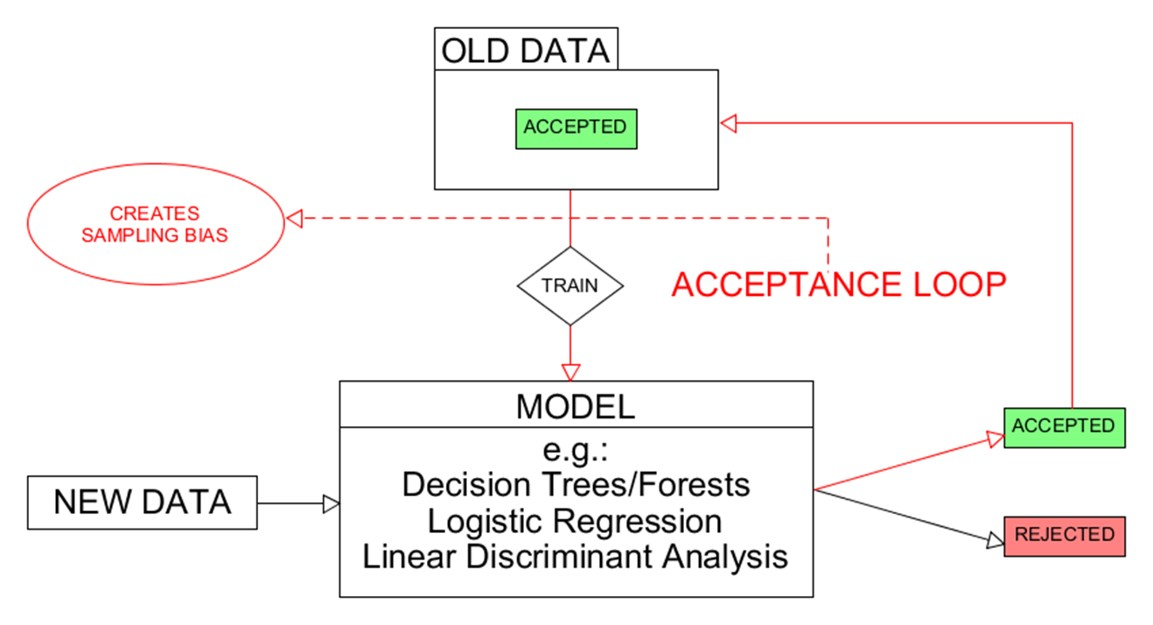"/>

_Figure 1_: Draft of an credit scoring model with the acceptance loop

In order to test any sampling bias minimizing reject inference methods, we need to measure the baseline sampling bias. This can be done simply by simulating the process described above of rating loan applications and iteratively retrain the rating model on additional cases it accepted previously. To then be able to measure the bias we compare the performance of the credit scoring model over time to a second model, we call Oracle, that was retrained on additional accepted and rejected cases in each iteration. This Oracle model is not possible in the real world but serves as a theoretically possible baseline for our tests, incorporating all the available information that we try to recover with our reject inference methods. An overview of how we operate the model, and the Oracle can be seen in Figure 2. It is important that, both the Oracle dataset and the model dataset receive the same number of datapoint after each iteration. By selecting the Oracle dataset cases randomly, we ensure that the Oracle model does not perform better solely due to a growing dataset to train on.

<img alt="Figure 2: Sketch of a dataset fed into a model and an oracle. Where only the accepted from the model are put into the training data of the model and the same amount from all are put into the training data of the oracle." src="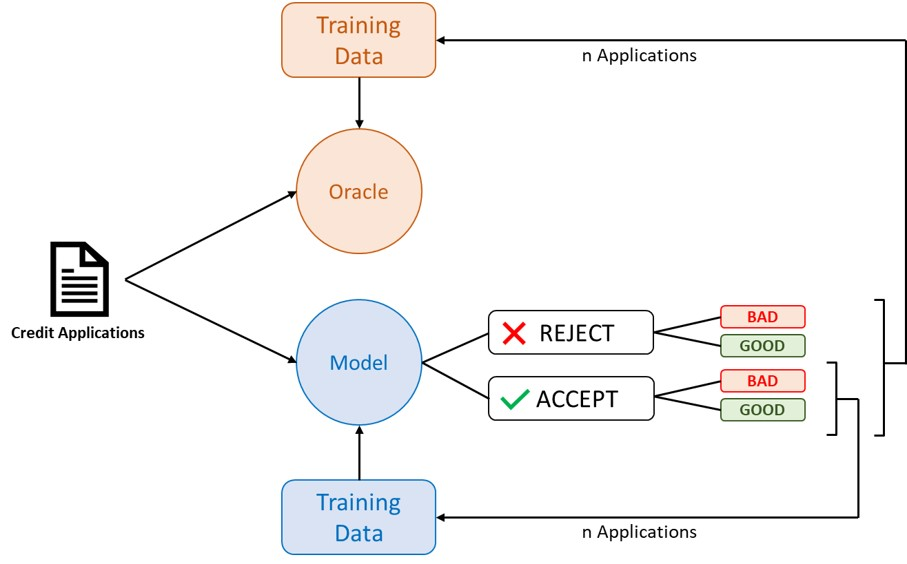"/>

_Figure 2_: Generation of different training data for oracle and model

In the first step, we split the data into three parts. The first fraction is for the initial model fitting of the Oracle model and our model. We put a second fraction aside to evaluate the Oracle and our model on each iteration. Lastly, the third fraction is used for the simulation, which is split down further into _n_ iterations.

The second step includes the training and evaluation of the Oracle and our model. First, we use both models to predict the data of the current iteration. Then, we update the training data for our model by adding all accepts (top 30% of applications) and update the training data for the Oracle by adding the same number of random applications. Lastly, we retrain both models on newer, larger datasets.

### 2.2. Our Implementation of the Acceptance Loop

We have developed a dedicated class, handling our credit scoring simulations. It allows for different experimental setups and keeps track of a variety of metrics to evaluate and compare results. In the following section we describe critical code blocks of that class in the notebook. Of course, this class is contained in a separate py file that is imported when we test our Autoencoder.

Let us first have a look at the constructor for that class, that handles all the data loading and preparation for the subsequent simulation and thus already receives a lot of parameters.

In [ ]:
class Simulate_acceptance_loop():

    def __init__(self, dataset_name: str, model, model_fit_split: float, holdout_test_split: float, n_loops: int, enc_features: bool = False, encoder: aenc.Autoencoder = None, rej_inf = None, incl_rejected: bool = False):
        self.n_loops = n_loops
        self.rej_inf = rej_inf

        # custom Transformer, that standard scales and then encodes the data with Autoencoder
        def std_enco(x):
            x_np = x.values.reshape(-1, x.shape[1]).astype('float32')
            x_trans = pre.StandardScaler().fit_transform(x_np)
            with torch.no_grad():
                x_encoded = encoder.encode(torch.from_numpy(x_trans)).numpy()
            return x_encoded

        # Either normal StandardScaler or StandardScaler and Encoder
        if enc_features:
            self.transformer  =  pre.FunctionTransformer(std_enco)
        else:
            self.transformer  = pre.StandardScaler()

>We will explore all the constructor’s parameters as we progress in the code. In the very first part of the initialization, we make the most important decision for the subsequent simulation: whether we want to run it on the original (standard scaled) or on the encoded features. If _encfeatures_ is set to true, we must provide a trained Autoencoder encoder as a parameter, that will encode data via a custom sklearn _FunctionTransformer_. Of course, before the data is encoded it is also standard scaled.
>
>The class allows for an optional parameter _rej_inf_, that must be a function that trains a model. This allows for some alternative, simpler reject inference methods, that rely on training models with specially weighted datapoints to fight sampling bias.

In [ ]:
        # load dataset
        complete_data = pd.read_csv(f'../prepared_data/{dataset_name}', sep=',')
        complete_data['BAD'] = np.where(complete_data['BAD'] == 'BAD', 1, 0).astype(np.int64)

        obj_cols = complete_data.select_dtypes('object').columns
        complete_data[obj_cols] = complete_data[obj_cols].astype('category')

        # For the sake of simplicity when dealing with neural nets later, let's just make everything categorical continous
        for col in obj_cols:
            woe_calc = h.IV_Calc(complete_data, feature=col, target='BAD')
            woe = woe_calc.full_summary()['WOE_adj'].to_dict()
            complete_data[col] = complete_data[col].map(woe)
            complete_data[col] = complete_data[col].astype('float64')

        complete_X = complete_data.iloc[:, complete_data.columns != 'BAD']
        complete_y = complete_data['BAD']

>Another important aspect follows, after the data is loaded by _dataset_name_ from the _prepared_data_ folder. In order to make things easier when testing different models and more importantly when handling the Autoencoder, we transform every non-numerical feature to be represented in terms of 'Weight of Evidence'. We then split our features from the target.

In [ ]:
        # get part of the data for inital model fitting
        X_remaining, X_model_fit, y_remaining, y_model_fit = train_test_split(complete_X, complete_y, test_size=model_fit_split, stratify=complete_y, random_state=123)

        # reserve holdout data for model evaluation
        X_simulation, X_holdout, y_simulation, y_holdout = train_test_split(X_remaining, y_remaining, test_size=holdout_test_split, stratify=y_remaining, random_state=123)

        self.holdout_test_X = X_holdout
        self.holdout_test_y = y_holdout

        # put simulation data back together
        self.simulation_data = pd.concat([X_simulation, y_simulation], axis=1)

        # initial fit of model and oracle model on remaining data
        self.model = model
        self.oracle = clone(model)

        self.transformer.fit(X_model_fit)
        X_model_fit_trans = self.transformer.transform(X_model_fit)
        self.model.fit(X_model_fit_trans, y_model_fit)

        self.oracle.fit(X_model_fit_trans, y_model_fit)

        # store all available train data
        self.all_train_X = X_model_fit
        self.all_train_y = y_model_fit

        self.oracle_all_train_X = X_model_fit
        self.oracle_all_train_y = y_model_fit

>We then define two splits in the data. The first split, governed by the variable _model_fitsplit_, removes a first fraction of the loaded data set and puts it aside to train our initial model. We need this part of the data because a trained model is already required in the first iteration of our simulation to accept and reject applications. The parameter that determines the size of that initial split has an important impact on the observable sampling bias as we will see below.
>
>The second split, specified by _holdout_testsplit_, takes away another fraction of the remaining data, this time to be used as a consistent test set to evaluate model performances during the simulation.
>
>We then transform the data of the initial model fitting, so either just standard scale it or encode it using a trained Autoencoder and fit the model initially. It is mportant to notice that we create an exact copy of the supplied model, Oracle, that we initially fit with the same data. This Oracle model copy will be actively hindered to run into the acceptance loop, to have a theoretical upper bound for model performance without any sampling bias.
>
>For the subsequent simulation we must keep track of all the available training data throughout each iteration, which is done in the _all_train_ attributes of the class.
>
>The class has only one method, _run_, which is an iterator that yields some information and metrics after each iteration of our simulation. Having the simulation take place in an iterator simplifies dealing with large amounts of data, which we later will.

In [ ]:
def run(self, accpet_fraction = 0.3):

        self.simulation_data = self.simulation_data.sample(frac=1, random_state=123)
        self.data_splits = np.array_split(self.simulation_data, self.n_loops)

        metrics = {"model": {"rolling": {"roc_auc": [], "accuracy": [], "f1": [], "precision": []},
                    "holdout": {"roc_auc": [], "accuracy": [], "f1": [], "precision": []}},
                "oracle": {"rolling": {"roc_auc": [], "accuracy": [], "f1": [], "precision": []},
                    "holdout": {"roc_auc": [], "accuracy": [], "f1": [], "precision": []}}}

>First, the remaining simulation data is shuffled and split up into _nloops parts, corresponding to the number of iterations we wish to simulate. Secondly, we define a dictionary that will keep track of the metrics we will evaluate during each simulation iteration. The simulation itself is essential for the following loop.

In [ ]:
        for year in range(self.n_loops):
            # 1. get the new data for that year
            new_data = self.data_splits[year].reset_index(drop=True)
            X = new_data.iloc[:, new_data.columns != 'BAD']
            y = new_data['BAD']
            
            # 2. predict data for this year with model and oracle
            predicted_proba = self.model.predict_proba(self.transformer.transform(X))[:, 1]
            predicted_proba_oracle = self.oracle.predict_proba(self.transformer.transform(X))[:, 1]

            threshold = sorted(predicted_proba)[floor(len(predicted_proba)*accpet_fraction)] # accept top n% of aplicants
            if threshold == 0.0: threshold = 0.0001 # needed to allow for pure Tree Classifier Leafs

            predicted_abs = np.where(predicted_proba < threshold, 0, 1)
            predicted_abs_oracle = np.where(predicted_proba_oracle < 0.5, 0, 1)

            # 3. add accepted data points to all available training data
            accepted = [True if x == 0 else False for x in predicted_abs]
            
            self.all_train_X = pd.concat([self.all_train_X, X[accepted]], ignore_index=True)
            self.all_train_y = pd.concat([self.all_train_y, y[accepted]], ignore_index=True)

            # 3.2 add same number of points (but random points - so no acceptance bias) to oracle model
            random.shuffle(accepted)
            self.oracle_all_train_X = pd.concat([self.oracle_all_train_X, X[accepted]], ignore_index=True)
            self.oracle_all_train_y = pd.concat([self.oracle_all_train_y, y[accepted]], ignore_index=True)

            # verbose
            # print(f'Itteration: {year}) Accepted: {accepted.count(True)} | Denied: {accepted.count(False)} - New train set size: {self.all_train_X.shape}')

>The loop can be considered in two separate steps. The first part of each iteration, or years, prepares the according chunk of 'fresh' data for that iteration, representing this year’s new applicants. We use our latest available model and Oracle, stored in the respective class attributes, to predict whether an applicant will default or not. To deal with the commonly heavy imbalance in credit risk data sets, we determine a variable threshold as a cut off probability to assign absolute values to the applications. (1 = BAD, meaning we will not accept that application, 0 = GOOD, meaning this application will be accepted and we can therefor observe its true label) This way we always accept roughly the same number of applicants in each iteration and can influence this amount. The amount of good applicants we accept is an important business decision that would need to be fine-tuned along a cost matrix, considering opportunity costs and risks. Given that this was outside the scope of our project, we set up the loop to accept the top 30% of applications each year by default, which seemed to work well for us.
>
>We then update the models available training data by adding all the applicants it has just accepted with their true, observed labels. Furthermore, we update the Oracles available training data by adding the same amount of randomly selected accepted and rejected cases of the current iteration. Again, also with the true labels, that we can in this case only know in this experimental setup. Thus, the name Oracle, as it magically knows the true labels of applications that were never granted the loan.

In [ ]:
            predicted_abs = np.where(predicted_proba < 0.5, 0, 1)

            # 4.1 save rolling_metrics for data of that year
            metrics["model"]["rolling"]['roc_auc'].append(roc_auc_score(y, predicted_proba))
            metrics["model"]["rolling"]['accuracy'].append(accuracy_score(y, predicted_abs))
            metrics["model"]["rolling"]['f1'].append(f1_score(y, predicted_abs))
            metrics["model"]["rolling"]['precision'].append(precision_score(y, predicted_abs))

            metrics["oracle"]["rolling"]['roc_auc'].append(roc_auc_score(y, predicted_proba_oracle))
            metrics["oracle"]["rolling"]['accuracy'].append(accuracy_score(y, predicted_abs_oracle))
            metrics["oracle"]["rolling"]['f1'].append(f1_score(y, predicted_abs_oracle))
            metrics["oracle"]["rolling"]['precision'].append(precision_score(y, predicted_abs_oracle))

            # 4.2 save metrics on evaluation hold out
            predicted_proba = self.model.predict_proba(self.transformer.transform(self.holdout_test_X))[:, 1]
            predicted_abs = np.where(predicted_proba < 0.5, 0, 1)

            predicted_proba_oracle = self.oracle.predict_proba(self.transformer.transform(self.holdout_test_X))[:, 1]
            predicted_abs_oracle = np.where(predicted_proba_oracle < 0.5, 0, 1)

            metrics["model"]["holdout"]['roc_auc'].append(roc_auc_score(self.holdout_test_y, predicted_proba))
            metrics["model"]["holdout"]['accuracy'].append(accuracy_score(self.holdout_test_y, predicted_abs))
            metrics["model"]["holdout"]['f1'].append(f1_score(self.holdout_test_y, predicted_abs))
            metrics["model"]["holdout"]['precision'].append(precision_score(self.holdout_test_y, predicted_abs))

            metrics["oracle"]["holdout"]['roc_auc'].append(roc_auc_score(self.holdout_test_y, predicted_proba_oracle))
            metrics["oracle"]["holdout"]['accuracy'].append(accuracy_score(self.holdout_test_y, predicted_abs_oracle))
            metrics["oracle"]["holdout"]['f1'].append(f1_score(self.holdout_test_y, predicted_abs_oracle))
            metrics["oracle"]["holdout"]['precision'].append(precision_score(self.holdout_test_y, predicted_abs_oracle))

            # 5. train model on all available data to improve
            self.transformer.fit(self.all_train_X)
            all_train_X_trans = self.transformer.transform(self.all_train_X)

            self.transformer.fit(self.oracle_all_train_X)
            oracle_all_train_X_trans = self.transformer.transform(self.oracle_all_train_X)
            
            if(self.rej_inf is None):
                self.model.fit(all_train_X_trans, self.all_train_y)
            else:
                self.rej_inf.fit(self.model,all_train_X_trans, self.all_train_y)
                
            self.oracle.fit(oracle_all_train_X_trans, self.oracle_all_train_y)

            yield year, accepted, all_train_X_trans.shape, metrics

        return metrics

>In the second part of each iteration, we then evaluate the current models. We do this on the current split of data for that iteration, but more importantly on the predefined holdout set. All the metrics are saved in the metrics dictionary that is yielded after every iteration.
>
>After that, we retrain the model on the new additional data that was gathered in that iteration. Prior to this, we standard scale and or encode the data. If specified, the _rejinf function is used to train the model.
>
>This concludes one iteration and our dynamic acceptance loop simulation, which we use to "create" measurable sampling bias to check our Autoencoder against.

To demonstrate the sampling bias created through this process, we can import the _Simulate_acceptanceloop class as shown in the next cell.

In [1]:
import sys
sys.path.append('../src')
import importlib
import lightgbm as lgbm

# The dynamic acceptance loop simulation
import dyn_accept_loop as dal
importlib.reload(dal)

# Define number of iterations and model to use
n_years = 20
model = lgbm.LGBMClassifier()

# Initialize the simulation
sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=False, rej_inf=None)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics = iteration[3]

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 68)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 68)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 68)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 68)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 68)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 68)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 68)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 68)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 68)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 68)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 68)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 68)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

To obtain a comparable measure, not only for the model performance, for which we mainly use the ROC-AUC, but also explicitly for the sampling bias we observe, we have a small helper function that calculates the average performance lost against the theoretically perfect Oracle. This metric is not of significance, as it does not imply anything for our actual model’s performance, but it is still important to keep track off of our analysis.

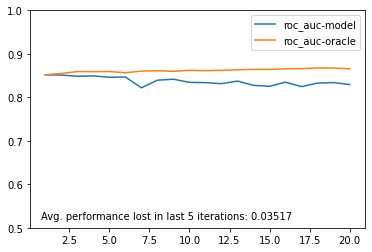

_Figure 3_: Development of ROC-AUC of both oracle and model with an average sampling bias of 0.03517 in the last 5 iterations

In [3]:
import helper as h
importlib.reload(h)
import matplotlib.pyplot as plt

# calculate performance loss over the last 5 years
last_n_years = 5
bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)

# Plot simulation results
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()

h.printmd(f'_Figure 3_: Development of ROC-AUC of both oracle and model with an average sampling bias of {round(bias, 5)} in the last 5 iterations')

As shown in Figure 3, by increasing number of iterations the Oracle clearly outperforms the model. Over the last five years, the average sampling-bias caused performance loss is about 3 percentage points.

## 3. Current Methods in Reject Inference

As we have seen credit risk model by design do not have target data for rejected applicants to train on. Since the applicants are in general not rejected at random, this introduces a sampling bias. To address this bias numerous reject inference methods have been developed. A recent overview can be found in Kozodoi et al. (2019). They all have in common that they, at least implicitly, have to consider the labels for rejected applicants as missing data. In regard to reject inference this was first explicitly done by Feelders (2000) based on the missing data classification from Little and Rubin (2002, first published 1987).

### 3.1.  Reject Inference as Missing Data Problem

To formalize the missing data treatment, it is important to look at the missing data mechanisms. The relation between the missing data and the features in the model. The data is called missing completely at random (MCAR) if the missingness is unrelated to the data. If it is related only to the observed values, it is called missing at random (MAR). But if it is related to the missing or unobserved values, it is called missing not at random (MNAR). (See Little and Rubin 2002, 11ff)

With regard to loglikelihood inference the missing-data mechanism is called ignorable if the data is MAR and the missing-data parameters and the model parameters are unrelated. (See Little and Rubin 2002, 119ff)

### 3.2. Missing Data in Existing Reject Inference Methods

To assume MCAR in the context of credit scoring it would be necessary to choose applicants at random. Moreover, in this situation we would not expect to see a sampling bias. Usually this is not the case and there is a selection process in place. A few rare studies with a dataset with almost no selection in place can be found in Banasik et al. (2003) and following works from Banasik and Crook (2004, 2005, 2007). Banasik et al. (2003) argue that the most important parameter in reject inference is the “accurate estimation of the potential good-bad ratio for the population of all applicants.” In general, the MCAR assumption is usually not applied in the credit scoring context. (See Feelders 2001 and Ehrhardt et al. 2021)

Most of the reject inference methods in the literature are based on an MAR ignorable assumption for the date. In the context of credit scoring this is a reasonable assumption. Since in general the credit decision is based on the model and therefore on the available data only. Although it should be noted that there are several mechanisms possible which are not fulfilling the assumption. Like overriding the model decision from a human in the process. Or if an applicant decides to accept the offer from another institute. Erhardt et al. (2021) use “not financed” instead of “rejected” to point out this distinction. Similarly, there might be other mechanisms which are not covered by the model. (See Feelders 2001 and Ehrhardt et al. 2021)

Erhardt et al. (2021) categorize and try to formalize reject inference methods even if this hasn’t been done formally. Based on these categories there are five types of methods based on MAR ignorable assumptions. Including ignoring the rejected applicants which are also based on these assumptions. Further methods are fuzzy augmentation, reclassification, augmentation, and a method called twins. Not included are more recent methods based on isolation forests, Bayesian networks Support Vector Machines or Deep Learning. Almost all of these are also based on the MAR ignorable assumption. (See Ehrhardt et al. 2021)

To cover these mechanisms, one would need to assume MNAR data. This limits the available statistical methods considerably. Therefore, there are only a few reject inference methods which are based on this assumption. In the literature only Parcelling and a bivariate probit model with sample selection can be considered. Whether the additional information to cover the MNAR mechanisms can be reasonably provided is not clear. (See Feelders 2001 and Ehrhardt et al. 2021)

To update the sketch of the model we now also keep the data on the rejected applicants to train the model in a feedback loop with the chosen reject inference method. This can be seen in Figure 4. It is to be noted here that the mentioned labelling is not done in all kinds of reject inference methods but rather functions as a contextual example.


<img alt="Figure4: Sketch of a credit scoring model where rejected and accepted fed back into the mmodel. And an additional loop from the model to the model saying Label rejects using RI techniques" src="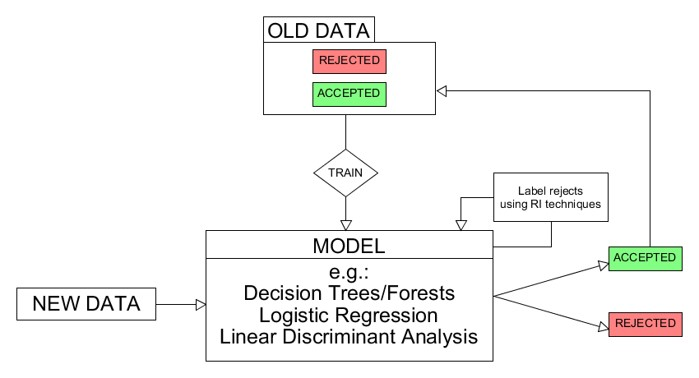"/>

_Figure 4_: Draft including now also the rejected for training the model and the Reject Inference loop

We implemented a simple augmentation method as a reference for our work. The method predicts the probabilities for every case once and then uses the inverse probabilities as weights. This intends to give more importance to those sample we assume to be most similar to the rejected. An iterative version would repeat this process until convergence.

In [4]:
class augmentation():
    def __init__(self, iterative: bool = False):
        self.iterative = iterative

    def fit(self, model, x,y):
        mod = clone(model)
        mod.fit(x, y)
        prev_pred = mod.predict_proba(x)[:,0]
        improv = 1
        i = 0
        if(self.iterative):
            while(improv > 0.0001 and i < 1000):
                weights = np.divide(1,prev_pred,out=np.ones_like(prev_pred)/0.000001,where=prev_pred!=0)
                model.fit(x, y, weights)
                pred = model.predict_proba(x)[:,0]
                improv = sum((prev_pred - pred)**2)
                prev_pred = pred
                i =+ 1
        else:
            weights = np.divide(1,prev_pred,out=np.ones_like(prev_pred)/0.000001,where=prev_pred!=0)
            model.fit(x, y, weights)

Running the acceptance loop with the same model as above and the simple augmentation method.

In [ ]:
# Load the reject inference definitions
import reject_inference as rinf
importlib.reload(rinf)

# Run simulation with reject inference
sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=False, rej_inf=rinf.augmentation())#rinf.EMsemisupervised)
results_generator = sim.run()

metrics_augm = None
for iteration in results_generator:
    #print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics_augm = iteration[3]

#compare to the roc to the original oracle
bias_augm = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics_augm["model"]["holdout"]['roc_auc'], last_n_years)

# Plot results from both runs
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics_augm["model"]["holdout"]['roc_auc'], label = 'roc_auc-model w augmentation')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(bias_augm, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()

h.printmd(f'_Figure 5_: Development of ROC-AUC of model compared to the results from above without.')
print(f'Sampling Bias with augmentation: {round(bias_augm, 5)}')
print(f'Reduction in Sampling Bias: {round((bias - bias_augm)/bias,2)*100}%')

As seen in Figure 5 the overall effect is small, which is most likely due to chance. It still loses performance with the iterations, whilst receiving more data to learn from.

### 3.3. Missing Data in this Project

In our project we also assume MAR ignorable date. Assuming the data coming from a single distribution and all the missing data mechanisms covered by the model. For our experiments these assumptions should be completely fulfilled. The full data is known and exclusion based solely on the model. In reality this would probably not be the case. Especially since we treat the available datasets as through-the-door-population, which are most likely already only datasets on accepted applicants, where we simulate a second rejection mechanism on top. In addition to other missing data mechanisms, the through-the-door-population will have a different distribution, which cannot be covered in our experiments on the available datasets.

## 4. Autoencoder

Autoencoders have first been introduced in Rumelhart et al. (1986). An Autoencoder is a special type of neural network that is trained to copy its input to its output. An Autoencoder learns to compress the data while minimizing the reconstruction error. It is formally defined in Baldi (2012). It consists of two parts. An encoder, which reduces the dimensionality of the input, and therefore imposes a bottleneck.  And the decoder, that uses this compressed data to reconstruct the input. The target is to minimize the overall error introduced by this process by minimizing the loss function. The different loss functions will be discussed in a later section. (See Bank et al. 2021)

Encoded data ideally holds as much information as possible. This is achieved by forcing the decoder to reconstruct the input data only from the encoded data. Therefore, the decoder can be used to verify the quality of the encoder. The encoder and decoder are neural networks, but in the special case that both parts consist only of linear operations, we get a linear Autoencoder.(Baldi and Hornik 1989) This linear Autoencoder, provided we drop its non-linear operations, would produce the same latent representation of the data like the Principal Component Analysis (PCA).(Plaut 2018) Essentially, PCA minimizes the squared reconstruction loss by linearly and optimally projecting data points in lower dimensional space (Wold et al. 1987).  This can be outperformed by a non-linear Autoencoder. (See Bank et al. 2021)

There are several applications for Autoencoders, which we will briefly outline. For a more detailed overview see Bank et al. (2021). This part is based on their work.

* First off, Autoencoders are used for dimensionality reduction. This is performed by every Autoencoder in the bottleneck layer and the base of most upcoming applications. As a standalone effect, the goal of dimensionality reduction is to reach the so-called “intrinsic dimensionality” to counteract the curse of dimensionality, which often appears in high dimensional space.

* A second application for Autoencoders is classification. While Autoencoders are mainly found in unsupervised learning, they can also be used to improve classification results in a semi-supervised setting, where only a small portion of the given data set is labelled. Here, the encoder is used to extract features. 


* Third, Autoencoders can also be used in clustering, an unsupervised learning technique, where we use the output of the encoder for the clustering algorithm. 


* A fourth application is anomaly detection. Here, Autoencoders would learn the profile of normal data examples via the latent subspace, which would lead to a high reconstruction error for anomalies.


* Lastly, Autoencoders can be used as a generative model, that use probabilistic distribution to generate data. In particular, this will be applied via Variational Autoencoders (VAE), which we will be discussing in the next section.


### 4.1.	Variational Autoencoder

Variational Autoencoders have first been introduced in Kingma et al. (2014). It is based on Variational Bayesian methods. As described in the prior section, VAEs are mainly used for generative models that attempt to describe data generation through a probabilistic distribution. The posterior distribution is approximated by a variational distribution. The latter is assumed to come from the same exponential family. In contrast to a vanilla Autoencoder, where the input data is mapped to a fixed vector, in the variational Autoencoder the input data is mapped onto a distribution. In the multivariate Gaussian case, the bottleneck vector will be replaced by two separate vectors: the mean vector and the standard deviation vector. Additionally, a new loss function will be implemented, which consists of two terms: The Kullback-Leibler divergence and reconstruction loss. The main goal of this loss function is to force our distribution to be as close to the variational distribution, in our case a standard multivariate normal distribution, as possible, while also keeping the reconstruction loss as small as possible.(See Kingma et al. 2014 and Bank et al. 2021) 

Unfortunately, we were not able to implement a working Variational Autoencoder due to time constraints.


### 4.2. Our implementation of an Autoencoder

We decided to build our Autoencoder implementation with PyTorch. PyTorch usually expect tensors for the implementations. Further, we want to do standard pre-processing on the datasets, which we already implemented with pandas. Therefore, we need to convert these after pre-processing to tensors. Also, our idea is to work on the differences between good and bad cases. In datasets with a highly disproportionate ratio between these a systematic reconstruction error on the smaller subset would have less influence. Assuming the good cases in the datasets are always more, we want to under-sample the good cases such that we have the same subset size between good and bad cases. To achieve all this, we build a dataload function.

In [ ]:
# load data from csv file, woe encode categorical features (TO-DO), standardize values, make tensor with shape [n_rows, n_features]
def load_data_to_tensor(dataset_name):
    complete_data = pd.read_csv(f'../prepared_data/{dataset_name}', sep=',')
    complete_data['BAD'] = np.where(complete_data['BAD'] == 'BAD', 1, 0).astype(np.int64)

    # We down sample the GOOD datapoints to even out the imbalance in the data set
    complete_data = pd.concat([complete_data[complete_data['BAD'] == 0].sample(complete_data['BAD'].value_counts()[1],random_state=37841), complete_data[complete_data['BAD'] == 1]])

    obj_cols = complete_data.select_dtypes('object').columns
    complete_data[obj_cols] = complete_data[obj_cols].astype('category')

    # For the sake of simplicity when dealing with neural nets later, let's just make everything categorical continous
    for col in obj_cols:
        woe_calc = h.IV_Calc(complete_data, feature=col, target='BAD')
        woe = woe_calc.full_summary()['WOE_adj'].to_dict()
        complete_data[col] = complete_data[col].map(woe)
        complete_data[col] = complete_data[col].astype('float64')

    ###### TRAIN ENCODER ON SUBSET OF THE DATA ########################
    #complete_data = complete_data[complete_data['BAD'] == 0]    # Only on BAD (1) or GOOD (0)
    #print(f'Shape of Autoencoder training data: {complete_data.shape}')
    ###################################################################

    complete_X = complete_data.iloc[:, complete_data.columns != 'BAD']
    complete_y = complete_data['BAD']

    x_np = complete_X.values.reshape(-1, complete_X.shape[1]).astype('float32')
    y_np = complete_y.values.reshape(-1, 1).astype('float32')

    # stadardize values
    standardizer = StandardScaler()
    x_stand = standardizer.fit_transform(x_np)

    return torch.from_numpy(x_stand), torch.from_numpy(y_np)

This function is used by our implementation of a dataset class which implements only the necessary functions _getitem_ and _length_ for the dataloader.

In [ ]:
# Custom Dataset class, that loads the standardized and prepared data from function load_data_to_tensor()
class CreditscoringDataset(Dataset):
    def __init__(self, dataset_name):
        self.x, self.y = load_data_to_tensor(dataset_name)
        
    def __getitem__(self,index):      
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

The actual Autoencoder class takes a shape parameter to test different configurations of the layers. The shape parameter needs to be indexable and contain integers with the expected sizes of the hidden layers. It warns if the last and the first layer of the shape are not of the same size. This would make it difficult to compare the input and the output to minimize the construction error. We then stack linear layers with sizes from the first given size up to the smallest as the encoder. Similarly, the decoder is built by stacking linear layers with sizes from the smallest to last given value in the shape parameter.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, shape):
        super(Autoencoder, self).__init__()

        if shape[0] != shape[-1]:
            print('Warning! First and last layer of encoder do not have the same size.')

        self.enc = nn.ModuleList()
        self.dec = nn.ModuleList()

        # Build encoder part
        for i in range(shape.index(min(shape))):
            self.enc.append(nn.Linear(in_features = shape[i], out_features = shape[i + 1]))
        
        # Build decoder part
        for i in range(shape.index(min(shape)), len(shape) - 1):
            self.dec.append(nn.Linear(in_features = shape[i], out_features = shape[i + 1]))

> The class provides separate encode and decode functions. This gives us the possibility to use only the encoder part on our dataset after the training on the neural network and train a credit scoring model based on the encoded data. The forward function is needed for the training of the neural network and just calls the encoder and afterwards decoder part.

In [ ]:
    def forward(self, x):
        x = self.decode(self.encode(x))
        return x

    def encode(self, x):
        for e in self.enc:
            x = torch.tanh(e(x))
        return x
        
    def decode(self, x):
        for d in self.dec:
            x = torch.tanh(d(x))
        return x

### 4.3. How could an Autoencoder help with sampling selection bias? - Loss Function

The idea that we pursue in this project, is to build an Autoencoder that represents credit scoring data in a way that looks very similar for GOOD and BAD applications, to avoid any sampling bias that occurs from seeing only one "kind" of data, characterized by different distributions of feature values. At the same time this representation needs to preserve as much of the original available information as possible.

Arguably, the most important part of our project is the way we intend to train our Autoencoder. We would not expect a vanilla Autoencoder that only compresses the data to a latent feature space to have any positive effect on the sampling bias. It is however not per se impossible that a simple compression improves the sampling bias. If we get lucky, the latent feature space lacks parts of the data that are more responsible for the sampling bias than others. This thus of course implies that we could also get unlucky and obtain a representation of the data which distributions are even more skewed between GOOD and BAD samples. In the next part of this notebook, we will investigate the effect on the sampling bias of vanilla, compression-only, Autoencoders further.

To favour the training of latent feature spaces where the distributions of features for the GOOD and BAD subset of the data are as alike as possible, we explicitly tell the Autoencoder to create them. This is done via the loss function.

In fact, we have to objectives we want our Autoencoder to keep in mind while training its weights and therefore a latent space representation of our data.

1. Preserve as much of the originally available information as possible.
1. The distribution of feature values should look as similar as possible for the GOOD (accepted) and BAD (rejected) subset of the data.

Important to note is the fact that we made the simplification of GOOD = accepted and BAD = rejected in the Autoencoder training process. We argue that it is reasonable to do this simplification, since we know from extensive testing in the previous part, that our models fit the data very well and effortlessly perform with ROC-AUCs around 85%. Thus, the error we make compared to using actually predicted rejected and accepted labels is relatively small, whereas the simplification in code and training time is very large.

Additionally, for the same reason, we train the Autoencoder on the whole dataset before our actual simulation of the credit granting process takes place. That is again unrealistic and even impossible in the real world, but a necessary simplification in our setup to run the simulations in a feasible time. We are foremost interested in the proof of concept of building an Autoencoder that helps with reject inference and to explore which parameters make it work or fail.

To train our Autoencoder along our two objectives we implemented the following function.

In [ ]:
# train any net
def train(net, trainloader, epochs, learningrate, lossFuncWeights, verbose = True):
    criterion = nn.MSELoss()
    criterion2 = nn.KLDivLoss(log_target=True, reduction="batchmean")
    criterion3 = mmd.MMD_loss()
    optimizer = optim.Adam(net.parameters(), lr=learningrate)

    train_loss = []
    train_loss_mmse = []
    train_loss_mmd = []
    train_loss_kld = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_loss_mmse = 0.0
        running_loss_mmd = 0.0
        running_loss_kld = 0.0
        for data in trainloader:
            data_x, data_y = data
            optimizer.zero_grad()
            outputs = net(data_x)
            encoded = net.encode(data_x)

            # split encoded data into good and bad subsets
            good = [True if x == 0 else False for x in data_y]
            enc_good = encoded[good]
            enc_bad = encoded[[not value for value in good]]
            #print(f'Enc_good shape: {enc_good.shape} Enc_bad shape: {enc_bad.shape}')

            # build MultiNorm Distributions from subsets and create log_probs of enc_good for both distributions to compare with KLDIVLOSS
            MN_dist_good = dis.multivariate_normal.MultivariateNormal(torch.mean(enc_good, dim=0), torch.corrcoef(torch.transpose(enc_good, 0, 1)))
            MN_dist_bad = dis.multivariate_normal.MultivariateNormal(torch.mean(enc_bad, dim=0), torch.corrcoef(torch.transpose(enc_bad, 0, 1)))

            sample = MN_dist_good.sample((1000,))

            enc_good = enc_good[:min([len(enc_good),len(enc_bad)])]
            enc_bad = enc_bad[:min([len(enc_good),len(enc_bad)])]

            # calculate criterions only if they influence the overall loss
            MMSELoss = criterion(outputs, data_x)                                                            if lossFuncWeights[0] > 0.0 else torch.zeros(1)
            KLDivLoss = criterion2(MN_dist_bad.log_prob(sample), MN_dist_good.log_prob(sample))  * 1000000   if lossFuncWeights[1] > 0.0 else torch.zeros(1)
            MMDLoss = criterion3(enc_good,enc_bad) * 10                                                      if lossFuncWeights[2] > 0.0 else torch.zeros(1)

            sum_loss = MMSELoss.item() + KLDivLoss.item() + MMDLoss.item()
            MMSELoss = sum_loss * MMSELoss / MMSELoss.item()    if lossFuncWeights[0] > 0.0 else torch.zeros(1)
            KLDivLoss = sum_loss * KLDivLoss / KLDivLoss.item() if lossFuncWeights[1] > 0.0 else torch.zeros(1)
            MMDLoss = sum_loss * MMDLoss / MMDLoss.item()       if lossFuncWeights[2] > 0.0 else torch.zeros(1)
            
            loss = lossFuncWeights[0] * MMSELoss + lossFuncWeights[1] * KLDivLoss + lossFuncWeights[2] * MMDLoss

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_loss_mmse += lossFuncWeights[0] * MMSELoss.item()
            running_loss_mmd += lossFuncWeights[2] * MMDLoss.item()
            running_loss_kld += lossFuncWeights[1] * KLDivLoss.item()

        loss = running_loss / len(trainloader)
        MMSELoss = running_loss_mmse / len(trainloader)
        MMDLoss = running_loss_mmd / len(trainloader)
        KLDivLoss = running_loss_kld / len(trainloader)
        train_loss.append(loss)
        train_loss_mmse.append(MMSELoss)
        train_loss_mmd.append(MMDLoss)
        train_loss_kld.append(KLDivLoss)
        
        if verbose: print('Epoch {} of {}, Train Loss: {:.4f} (MMSE: {:.4f} | MMD: {:.4f} | KLD: {:.4f})'.format(epoch+1, epochs, loss, MMSELoss, MMDLoss, KLDivLoss))

    return train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld

The function is can train any torch network along a three-part loss function. The three loss criterions we chose to implement are the Minimum Mean Squared Error Loss (MMSELoss) for the standard reconstruction term and the Kullback-Leibler-Divergence (KLDivLoss) as well as the Maximum Mean Discrepancy (MMDLoss) as a penalty for unlike distributions between the GOOD and BAD subset of our data. Both the KLD and the MMD are a measure for the distance between two distributions and have smaller values for distributions that look more alike, which is a property we want our latent feature space to have.

The function implements a very standard way to train neural networks in PyTorch using a data loader that provides batches and multiple epochs that each exhaust all available batches. The thing that is special for our train function is the way we incorporate the distribution mismatch penalty. The KLDivLoss is a predefined PyTorch loss function, that is capable of operating on batches, which is very convenient. With it we want to penalize, so increase the overall loss, if the encoder part of our Autoencoder does not find a compression of the data that has alike statistical properties for the GOOD and BAD subset of our data. The KLDivLoss method expects the log-likelihood of a sample coming from the two distributions it compares. To obtain these log-likelihoods we therefore create two multivariate normal distributions from the encoded GOOD and BAD subsets of each batch. We then generate 1.000 samples from the GOOD distribution to calculate the log-likelihood of the samples coming from either distribution. If the distributions are very alike, the log-likelihoods will also be alike, resulting in a lower loss.

We also calculate the MMDLoss, which operates directly on the encoded batch data. The GOOD and BAD subset need to be of the same size, though.

Together with the basic MMSE reconstruction error, that compares the decoded net output to the original input, the two loss criterions are weighted and summed into the overall loss. Along this loss, the ADAM optimizer updates the network.

To later plot the loss function components individually we keep track of them and return them after the training is complete.

<img alt="Figure 6: Sketch of a credit scoring model fed by the latent space of an Autoencoder on top trained on the rejected and accepted. The new data going into the model is going through an encoder of the same shape as the encoder part of the Autoencoder." src="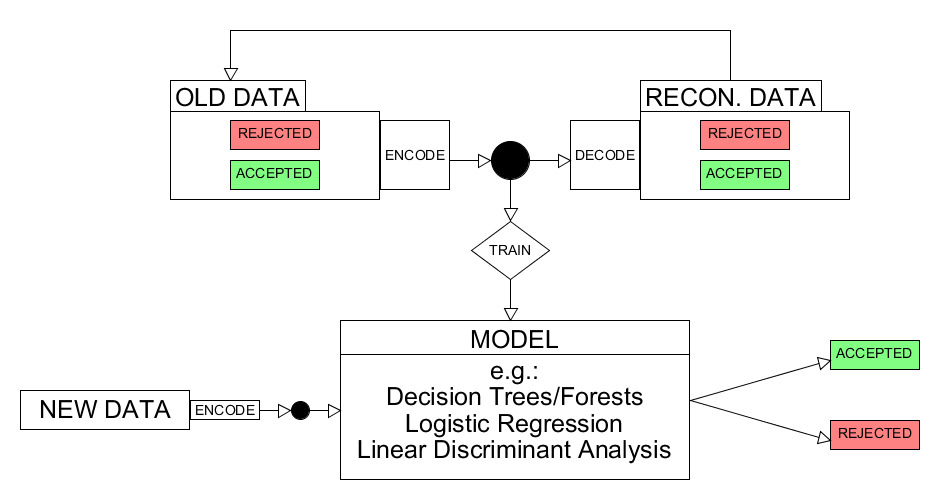"/>

_Figure 6_: Draft with additional Autoencoder

## 5. Testing and Results

Let's put everything together now. To make use of all the code fragments of this notebooks previous parts, we import the classes they belong to from separate python files.

In [6]:
import sys
sys.path.append('../src')

import importlib
# The dynamic acceptance loop simulation
import dyn_accept_loop as dal
importlib.reload(dal)
# Helper functions
import helper as h
importlib.reload(h)
# The Autoencoder
import autoencoder as aenc
importlib.reload(aenc)

import matplotlib.pyplot as plt

import lightgbm as lgbm

### 5.1 Compression-only

To see if the Autoencoder has a realistic chance to reduce the sampling bias and improve the model’s performance we need to check if the data at hand is compressible. We opted to use the _gmsc_ data set mostly, due to its size and the fact that it is not too biased towards the GOOD samples. Furthermore, it is purely numerical which is beneficial for our Autoencoder experiments, as we then know we do not use any performance due to WOE effects.

Let’s use the simulation class to obtain a baseline to test the effect of a vanilla Autoencoder against. The simulation iterates over 20 years, but we are only interested on the model’s performance over the past five years.

Baseline Sampling Bias: 0.03858
Baseline ROC-AUC: 0.82665


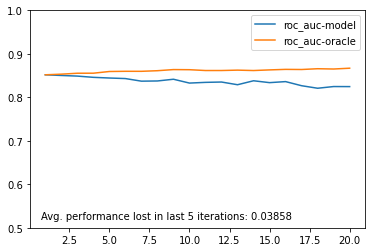

_Figure 7_: Development of ROC-AUC of baseline model and baseline oracle

In [11]:
# Define number of iterations and model to use (same as above)
n_years = 20
model = lgbm.LGBMClassifier()

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=False, rej_inf=None)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    metrics = iteration[3]

# calculate performance loss against oracle and models average ROC-AUC over the last 5 years
last_n_years = 5
baseline_bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
baseline_roc_auc = sum(metrics["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years
print(f'Baseline Sampling Bias: {round(baseline_bias, 5)}\nBaseline ROC-AUC: {round(baseline_roc_auc, 5)}')

# Plot simulation results
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(baseline_bias, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()
h.printmd(f'_Figure 7_: Development of ROC-AUC of baseline model and baseline oracle')

Over the last 5 years of this simulation, the model on average, performed with a ROC-AUC of about 0.83 and lost about 3.5 percentage points against the theoretical best possible performance. Let's now train a simple Autoencoder, that only aims to compress the data in the most reconstructable way. We do this, by setting the loss function weights for our distribution mismatch penalties to 0.0.

The original gmsc data set has 68 features. We can set the Autoencoder to try and compress it to five, for example. In between the latent layer we aim to train, let’s set hidden layers of an intermediate size, to allow for more freedom in the compression for our network.

Autoencoder(
  (enc): ModuleList(
    (0): Linear(in_features=68, out_features=35, bias=True)
    (1): Linear(in_features=35, out_features=5, bias=True)
  )
  (dec): ModuleList(
    (0): Linear(in_features=5, out_features=35, bias=True)
    (1): Linear(in_features=35, out_features=68, bias=True)
  )
)
Epoch 1 of 20, Train Loss: 0.8714 (MMSE: 0.8714 | MMD: 0.0000 | KLD: 0.0000)
Epoch 2 of 20, Train Loss: 0.6582 (MMSE: 0.6582 | MMD: 0.0000 | KLD: 0.0000)
Epoch 3 of 20, Train Loss: 0.6035 (MMSE: 0.6035 | MMD: 0.0000 | KLD: 0.0000)
Epoch 4 of 20, Train Loss: 0.5778 (MMSE: 0.5778 | MMD: 0.0000 | KLD: 0.0000)
Epoch 5 of 20, Train Loss: 0.5592 (MMSE: 0.5592 | MMD: 0.0000 | KLD: 0.0000)
Epoch 6 of 20, Train Loss: 0.5524 (MMSE: 0.5524 | MMD: 0.0000 | KLD: 0.0000)
Epoch 7 of 20, Train Loss: 0.5452 (MMSE: 0.5452 | MMD: 0.0000 | KLD: 0.0000)
Epoch 8 of 20, Train Loss: 0.5392 (MMSE: 0.5392 | MMD: 0.0000 | KLD: 0.0000)
Epoch 9 of 20, Train Loss: 0.5337 (MMSE: 0.5337 | MMD: 0.0000 | KLD: 0.0000)
Epoc

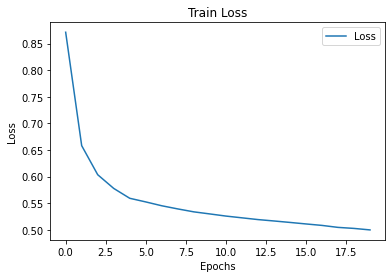

_Figure 8_: Train Loss of MMSE by number of Epochs trained

In [16]:
BATCH_SIZE = 2000
EPOCHS = 20
LR = 1e-2
# ONLY MMSE as single loss term for this first experiment
LOSSFUNCWEIGHTS = [1.0 ,0.0, 0.0]  #[MMSE, KLDiv, MMD]

dataset = aenc.CreditscoringDataset("gmsc.csv")      # load and prepare Dataset to Tensor
data_loader = aenc.DataLoader(                       # create Dataloader for batching
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

shape = [dataset.x.shape[1], 35, 5, 35, dataset.x.shape[1]]  # define shape of Autoencoder
net = aenc.Autoencoder(shape)
print(net)
net.to("cpu")

train_loss, train_loss_mmse, _, _ = aenc.train(net, data_loader, EPOCHS, LR, LOSSFUNCWEIGHTS, verbose = True)               

plt.figure()
plt.plot(train_loss, label='Loss')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

h.printmd(f'_Figure 8_: Train Loss of MMSE by number of Epochs trained')

We can now use the trained Autoencoder and pass it to our simulation class, to see the simulation being run on the encoded (to five latent features!) data.

Sampling Bias on encoded data: 0.01256
Sampling Bias encoded model against original unencoded baseline: 0.0313
ROC-AUC on encoded data: 0.83394


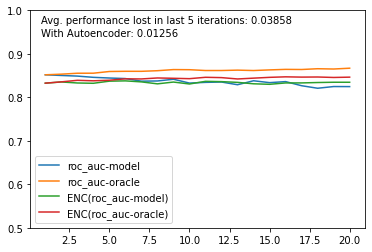

_Figure 9_: Development of ROC-AUC of model and oracle on encoded data compared to baseline

In [17]:
# Pass encoder in encoder parameter and set enc_features to True
sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net)
results_generator = sim.run()

metrics2 = None
for iteration in results_generator:
    metrics2 = iteration[3]

last_n_years = 5
bias2 = h.measure_bias(metrics2["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years)
bias2vsOriginal = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years)
roc_auc2 = sum(metrics2["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years
print(f'Sampling Bias on encoded data: {round(bias2, 5)}\nSampling Bias encoded model against original unencoded baseline: {round(bias2vsOriginal, 5)}\nROC-AUC on encoded data: {round(roc_auc2, 5)}')
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.text(0.75, 0.97, f'Avg. performance lost in last {last_n_years} iterations: {round(baseline_bias, 5)}')
plt.text(0.75, 0.94, f'With Autoencoder: {round(bias2, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()

h.printmd(f'_Figure 9_: Development of ROC-AUC of model and oracle on encoded data compared to baseline')

This looks good! The encoded data holds enough information to allow our model to perform with a nearly identical AUC! We noticeably reduced the sampling bias in the encoded case! That is however mostly because we lost a lot of performance in the Oracle model on encoded data. Compared to the true baseline we did not shrink the sampling bias much. (Which is also not really expected at this stage of course...)

### 5.2. With Distribution Missmatch Penalty

Let’s now add some distribution mismatch penalty to the loss function and hope it improves our results. To give back a little bit more freedom to the net and because we do not really care for the number of latent features, we can increase the latent feature size again.

Autoencoder(
  (enc): ModuleList(
    (0): Linear(in_features=68, out_features=45, bias=True)
    (1): Linear(in_features=45, out_features=25, bias=True)
  )
  (dec): ModuleList(
    (0): Linear(in_features=25, out_features=45, bias=True)
    (1): Linear(in_features=45, out_features=68, bias=True)
  )
)
Epoch 1 of 20, Train Loss: 0.9942 (MMSE: 0.1988 | MMD: 0.0000 | KLD: 0.7954)
Epoch 2 of 20, Train Loss: 0.7845 (MMSE: 0.1569 | MMD: 0.0000 | KLD: 0.6276)
Epoch 3 of 20, Train Loss: 0.6694 (MMSE: 0.1339 | MMD: 0.0000 | KLD: 0.5356)
Epoch 4 of 20, Train Loss: 0.5684 (MMSE: 0.1137 | MMD: 0.0000 | KLD: 0.4547)
Epoch 5 of 20, Train Loss: 0.5240 (MMSE: 0.1048 | MMD: 0.0000 | KLD: 0.4192)
Epoch 6 of 20, Train Loss: 0.4944 (MMSE: 0.0989 | MMD: 0.0000 | KLD: 0.3955)
Epoch 7 of 20, Train Loss: 0.5117 (MMSE: 0.1023 | MMD: 0.0000 | KLD: 0.4094)
Epoch 8 of 20, Train Loss: 0.5052 (MMSE: 0.1010 | MMD: 0.0000 | KLD: 0.4042)
Epoch 9 of 20, Train Loss: 0.4875 (MMSE: 0.0975 | MMD: 0.0000 | KLD: 0.3900)
Ep

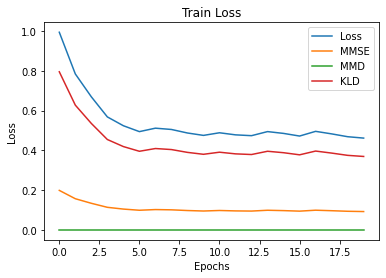

_Figure 10_: Train loss of both loss functions by epochs

In [23]:
BATCH_SIZE = 2000
EPOCHS = 20
LR = 1e-2

# MMSE + KLDiv
LOSSFUNCWEIGHTS = [0.2, 0.8, 0.0]  #[MMSE, KLDiv, MMD]

dataset = aenc.CreditscoringDataset("gmsc.csv")      # load and prepare Dataset to Tensor
data_loader = aenc.DataLoader(                       # create Dataloader for batching
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

shape = [dataset.x.shape[1], 45, 25, 45, dataset.x.shape[1]]  # define shape of Autoencoder
net = aenc.Autoencoder(shape)
print(net)
net.to("cpu")

train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = aenc.train(net, data_loader, EPOCHS, LR, LOSSFUNCWEIGHTS, verbose = True)               

plt.figure()
plt.plot(train_loss, label='Loss')
plt.plot(train_loss_mmse, label='MMSE')
plt.plot(train_loss_mmd, label='MMD')
plt.plot(train_loss_kld, label='KLD')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

h.printmd(f'_Figure 10_: Train loss of both loss functions by epochs')

Sampling Bias on encoded data: 0.01534
Sampling Bias encoded model against original unencoded baseline: 0.02223
ROC-AUC on encoded data: 0.84301


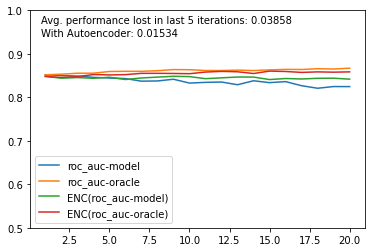

_Figure 11_: Development of ROC-AUC of model and oracle on encoded data with mismatch penalty compared to baseline

In [24]:
# Pass encoder in encoder parameter and set enc_features to True
sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net)
results_generator = sim.run()

metrics2 = None
for iteration in results_generator:
    metrics2 = iteration[3]

last_n_years = 5
bias2 = h.measure_bias(metrics2["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years)
bias2vsOriginal = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years)
roc_auc2 = sum(metrics2["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years
print(f'Sampling Bias on encoded data: {round(bias2, 5)}\nSampling Bias encoded model against original unencoded baseline: {round(bias2vsOriginal, 5)}\nROC-AUC on encoded data: {round(roc_auc2, 5)}')
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.text(0.75, 0.97, f'Avg. performance lost in last {last_n_years} iterations: {round(baseline_bias, 5)}')
plt.text(0.75, 0.94, f'With Autoencoder: {round(bias2, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()

h.printmd(f'_Figure 11_: Development of ROC-AUC of model and oracle on encoded data with mismatch penalty compared to baseline')

That looks even better! The ROC-AUC of the model operating on the encoded data is now noticeably higher than on the unencoded data. This can also be seen by the smaller sampling bias against the unencoded baseline.

Of course, there are a lot of parameters in play here and up until now we only randomly set them. It would make more sense to look at them and their effect on the model performance in a bigger range, to assess their influence better.

A side note on the MMD Loss: We found it to not work properly at all and in any configuration drastically lower the model performance while at the same time being very slow to train. We exclude it in any further experiments but leave it in the code to show that it theoretically can be used in future testing and development.

### 5.3. Influence of the Size of Latent Feature Space

We will now have a look at the effect the number of latent features has on the model performance and compare that to our baseline performance.

PARAM: 3 | Sampling Bias: 0.19678 // ROC-AUC: 0.66845
PARAM: 5 | Sampling Bias: 0.1866 // ROC-AUC: 0.67863
PARAM: 7 | Sampling Bias: 0.11951 // ROC-AUC: 0.74573
PARAM: 9 | Sampling Bias: 0.11779 // ROC-AUC: 0.74745
PARAM: 11 | Sampling Bias: 0.03346 // ROC-AUC: 0.83178
PARAM: 13 | Sampling Bias: 0.02775 // ROC-AUC: 0.83748
PARAM: 15 | Sampling Bias: 0.03169 // ROC-AUC: 0.83355
PARAM: 17 | Sampling Bias: 0.03706 // ROC-AUC: 0.82817
PARAM: 19 | Sampling Bias: 0.03625 // ROC-AUC: 0.82899
PARAM: 21 | Sampling Bias: 0.03741 // ROC-AUC: 0.82783
PARAM: 23 | Sampling Bias: 0.03073 // ROC-AUC: 0.83451
PARAM: 25 | Sampling Bias: 0.0228 // ROC-AUC: 0.84243
PARAM: 27 | Sampling Bias: 0.0305 // ROC-AUC: 0.83474
PARAM: 29 | Sampling Bias: 0.024 // ROC-AUC: 0.84124
PARAM: 31 | Sampling Bias: 0.02234 // ROC-AUC: 0.8429
PARAM: 33 | Sampling Bias: 0.02673 // ROC-AUC: 0.83851
PARAM: 35 | Sampling Bias: 0.02186 // ROC-AUC: 0.84338
PARAM: 37 | Sampling Bias: 0.02674 // ROC-AUC: 0.8385
PARAM: 39 | Sampling 

_Figure 12_: Development of ROC-AUC and sampling  bias of model encoded data by number of latent features compared to baseline

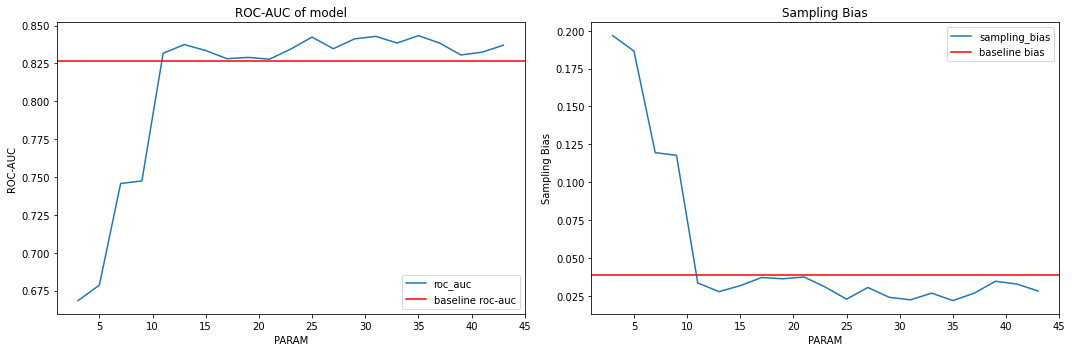

In [25]:
## -----------------------------------------------------------------------
## Loop through Autoencoder training and testing for a parameter
## -----------------------------------------------------------------------

BATCH_SIZE = 2000
EPOCHS = 20
LR = 1e-3

sampling_bias = []
roc_auc = []
startvalue = 3
stopvalue = 45
step = 2
for PARAM in range(startvalue, stopvalue, step):
    # Train Autoencoder
    LOSSFUNCWEIGHTS = [0.2, 0.8, 0.0]  #[MMSE, KLDiv, MMD]

    dataset = aenc.CreditscoringDataset("gmsc.csv")      # load and prepare Dataset to Tensor
    data_loader = aenc.DataLoader(                       # create Dataloader for batching
        dataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True
    )

    shape = [dataset.x.shape[1], 45, PARAM, 45, dataset.x.shape[1]]  # define shape of Autoencoder PARAM = 25
    net = aenc.Autoencoder(shape)
    #print(net)
    net.to("cpu")

    train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = aenc.train(net, data_loader, EPOCHS, LR, LOSSFUNCWEIGHTS, verbose=False)

    # Simulate on encoded Data to measure sampling bias

    sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net)#, rej_inf=rinf.EMsemisupervised)
    results_generator = sim.run()

    metrics2 = None
    for iteration in results_generator:
        #print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
        metrics2 = iteration[3]


    sampling_bias.append(h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years))
    roc_auc.append(sum(metrics2["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years)
    print(f'PARAM: {PARAM} | Sampling Bias: {round(sampling_bias[-1], 5)} // ROC-AUC: {round(roc_auc[-1], 5)}')

# Plot Results
x = range(startvalue, stopvalue, step)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(x, roc_auc, label = 'roc_auc')
axes[0].axhline(y = baseline_roc_auc, color = 'r', label = 'baseline roc-auc')
axes[0].legend()
axes[0].set_title("ROC-AUC of model")
axes[0].set_ylabel("ROC-AUC")
axes[0].set_xlabel("PARAM")

axes[1].plot(x, sampling_bias, label = 'sampling_bias')
axes[1].axhline(y = baseline_bias, color = 'r', label = 'baseline bias')
axes[1].legend()
axes[1].set_title("Sampling Bias")
axes[1].set_ylabel("Sampling Bias")
axes[1].set_xlabel("PARAM")
fig.tight_layout()
h.printmd(f'_Figure 12_: Development of ROC-AUC and sampling  bias of model encoded data by number of latent features compared to baseline')

As we can see the ROC-AUC of the model, working on the encoded data surpasses its unencoded baseline at about ten latent features in the bottleneck. This also corresponds to the sampling bias, which drops below the baseline at the same point. This indicates that the sampling bias reduction is the reason we can noticeably improve the performance of our credit scoring model!

### 5.4. Influence of Loss Function Weights

Another important parameter is probably the distribution of weights in our loss function. Do we want to focus more on the reconstruction error, or on the distribution divergence? Let’s also explore that, from one extreme to the other. Presumingly, if we emphasize the KLDiv term in the loss function we minimize the sampling bias between the encoded model and Oracle, but lose over all predictive performance compared to the unencoded original models. On the other hand, an overweighted MMSE reconstruction error term will not have much effect on the sampling bias and thus also will not improve the encoded models performance.

PARAM: 0 | Sampling Bias: 0.03455 // ROC-AUC: 0.83069
PARAM: 5 | Sampling Bias: 0.03332 // ROC-AUC: 0.83192
PARAM: 10 | Sampling Bias: 0.02878 // ROC-AUC: 0.83646
PARAM: 15 | Sampling Bias: 0.02813 // ROC-AUC: 0.83711
PARAM: 20 | Sampling Bias: 0.02263 // ROC-AUC: 0.84261
PARAM: 25 | Sampling Bias: 0.01937 // ROC-AUC: 0.84587
PARAM: 30 | Sampling Bias: 0.0291 // ROC-AUC: 0.83614
PARAM: 35 | Sampling Bias: 0.0228 // ROC-AUC: 0.84244
PARAM: 40 | Sampling Bias: 0.02511 // ROC-AUC: 0.84013
PARAM: 45 | Sampling Bias: 0.03686 // ROC-AUC: 0.82838
PARAM: 50 | Sampling Bias: 0.02711 // ROC-AUC: 0.83813
PARAM: 55 | Sampling Bias: 0.0247 // ROC-AUC: 0.84053
PARAM: 60 | Sampling Bias: 0.02213 // ROC-AUC: 0.8431
PARAM: 65 | Sampling Bias: 0.03316 // ROC-AUC: 0.83208
PARAM: 70 | Sampling Bias: 0.02986 // ROC-AUC: 0.83538
PARAM: 75 | Sampling Bias: 0.03584 // ROC-AUC: 0.8294
PARAM: 80 | Sampling Bias: 0.02946 // ROC-AUC: 0.83577
PARAM: 85 | Sampling Bias: 0.02784 // ROC-AUC: 0.83739
PARAM: 90 | Sampl

_Figure 13_: Development of ROC-AUC and sampling  bias of model encoded data by number of latent features compared to baseline

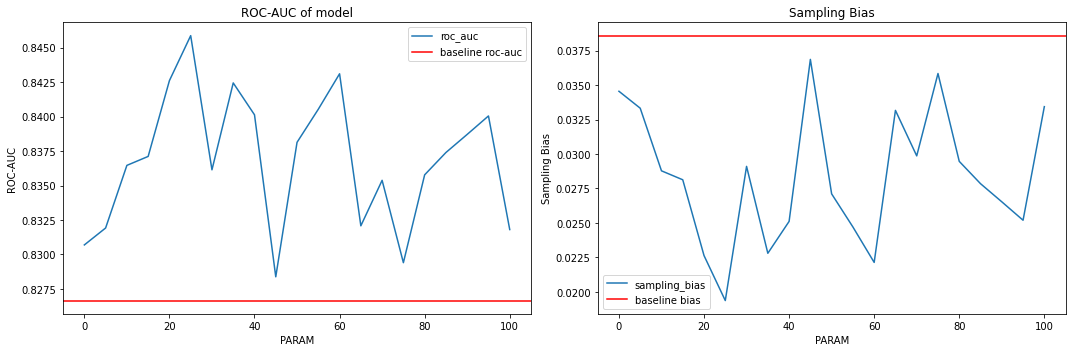

In [27]:
## -----------------------------------------------------------------------
## Loop through Autoencoder training and testing for a parameter
## -----------------------------------------------------------------------

BATCH_SIZE = 2000
EPOCHS = 20
LR = 1e-3

sampling_bias = []
roc_auc = []
startvalue = 0
stopvalue = 101
step = 5
for PARAM in range(startvalue, stopvalue, step):
    # Train Autoencoder
    LOSSFUNCWEIGHTS = [PARAM/100, 1 - PARAM/100, 0.0]  #[MMSE, KLDiv, MMD]

    dataset = aenc.CreditscoringDataset("gmsc.csv")      # load and prepare Dataset to Tensor
    data_loader = aenc.DataLoader(                       # create Dataloader for batching
        dataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True
    )

    shape = [dataset.x.shape[1], 45, 25, 45, dataset.x.shape[1]]  # define shape of Autoencoder PARAM = 25
    net = aenc.Autoencoder(shape)
    #print(net)
    net.to("cpu")

    train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = aenc.train(net, data_loader, EPOCHS, LR, LOSSFUNCWEIGHTS, verbose=False)

    # Simulate on encoded Data to measure sampling bias

    sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net)#, rej_inf=rinf.EMsemisupervised)
    results_generator = sim.run()

    metrics2 = None
    for iteration in results_generator:
        #print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
        metrics2 = iteration[3]


    sampling_bias.append(h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years))
    roc_auc.append(sum(metrics2["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years)
    print(f'PARAM: {PARAM} | Sampling Bias: {round(sampling_bias[-1], 5)} // ROC-AUC: {round(roc_auc[-1], 5)}')

# Plot Results
x = range(startvalue, stopvalue, step)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(x, roc_auc, label = 'roc_auc')
axes[0].axhline(y = baseline_roc_auc, color = 'r', label = 'baseline roc-auc')
axes[0].legend()
axes[0].set_title("ROC-AUC of model")
axes[0].set_ylabel("ROC-AUC")
axes[0].set_xlabel("PARAM")

axes[1].plot(x, sampling_bias, label = 'sampling_bias')
axes[1].axhline(y = baseline_bias, color = 'r', label = 'baseline bias')
axes[1].legend()
axes[1].set_title("Sampling Bias")
axes[1].set_ylabel("Sampling Bias")
axes[1].set_xlabel("PARAM")
fig.tight_layout()
h.printmd(f'_Figure 13_: Development of ROC-AUC and sampling  bias of model encoded data by number of latent features compared to baseline')

Interestingly the weighing of the two terms in the loss function does not seem to have a clear effect on the overall result. It seems that neither extreme is really good, but between 0.2 and 0.8 MMSE the performance shows no obvious trend. Additionally, the performance jumps heavily between very similar configurations, as if their effect was rather random. Maybe this has to do with the other, in this setup fixed, parameters.

### 5.5. Systematic Test of Hyperparameters

To investigate this further, we will perform ad extensive "Grid Search" to evaluate the whole spectrum of some parameter combinations. Specifically, we decided to look at the number of latent features, the weighing of the two loss function terms and the number of epochs the Autoencoder was trained.

Based on our exploration, we decided on weighting in 10%-steps between 0 and 1 for the MMSE loss with the KLDiv loss. Between 4 and 37 features with a step size of 3 in the latent space. And lastly, the number of epochs trained to increase by powers of 2 starting from 2 to 128. For a given set of weight and features, we trained the Autoencoder for the given number of epochs, trained the credit scoring model with data encoded by the network and then trained the network further epochs until the next target number of epochs. This is all included in _gridsearch.py_ script which we executed on a remote machine and only load the resulting data here.

In [28]:
import pickle
roc_auc_grid = pickle.load(open('roc-auc-flat_grid-result.p', 'rb'))

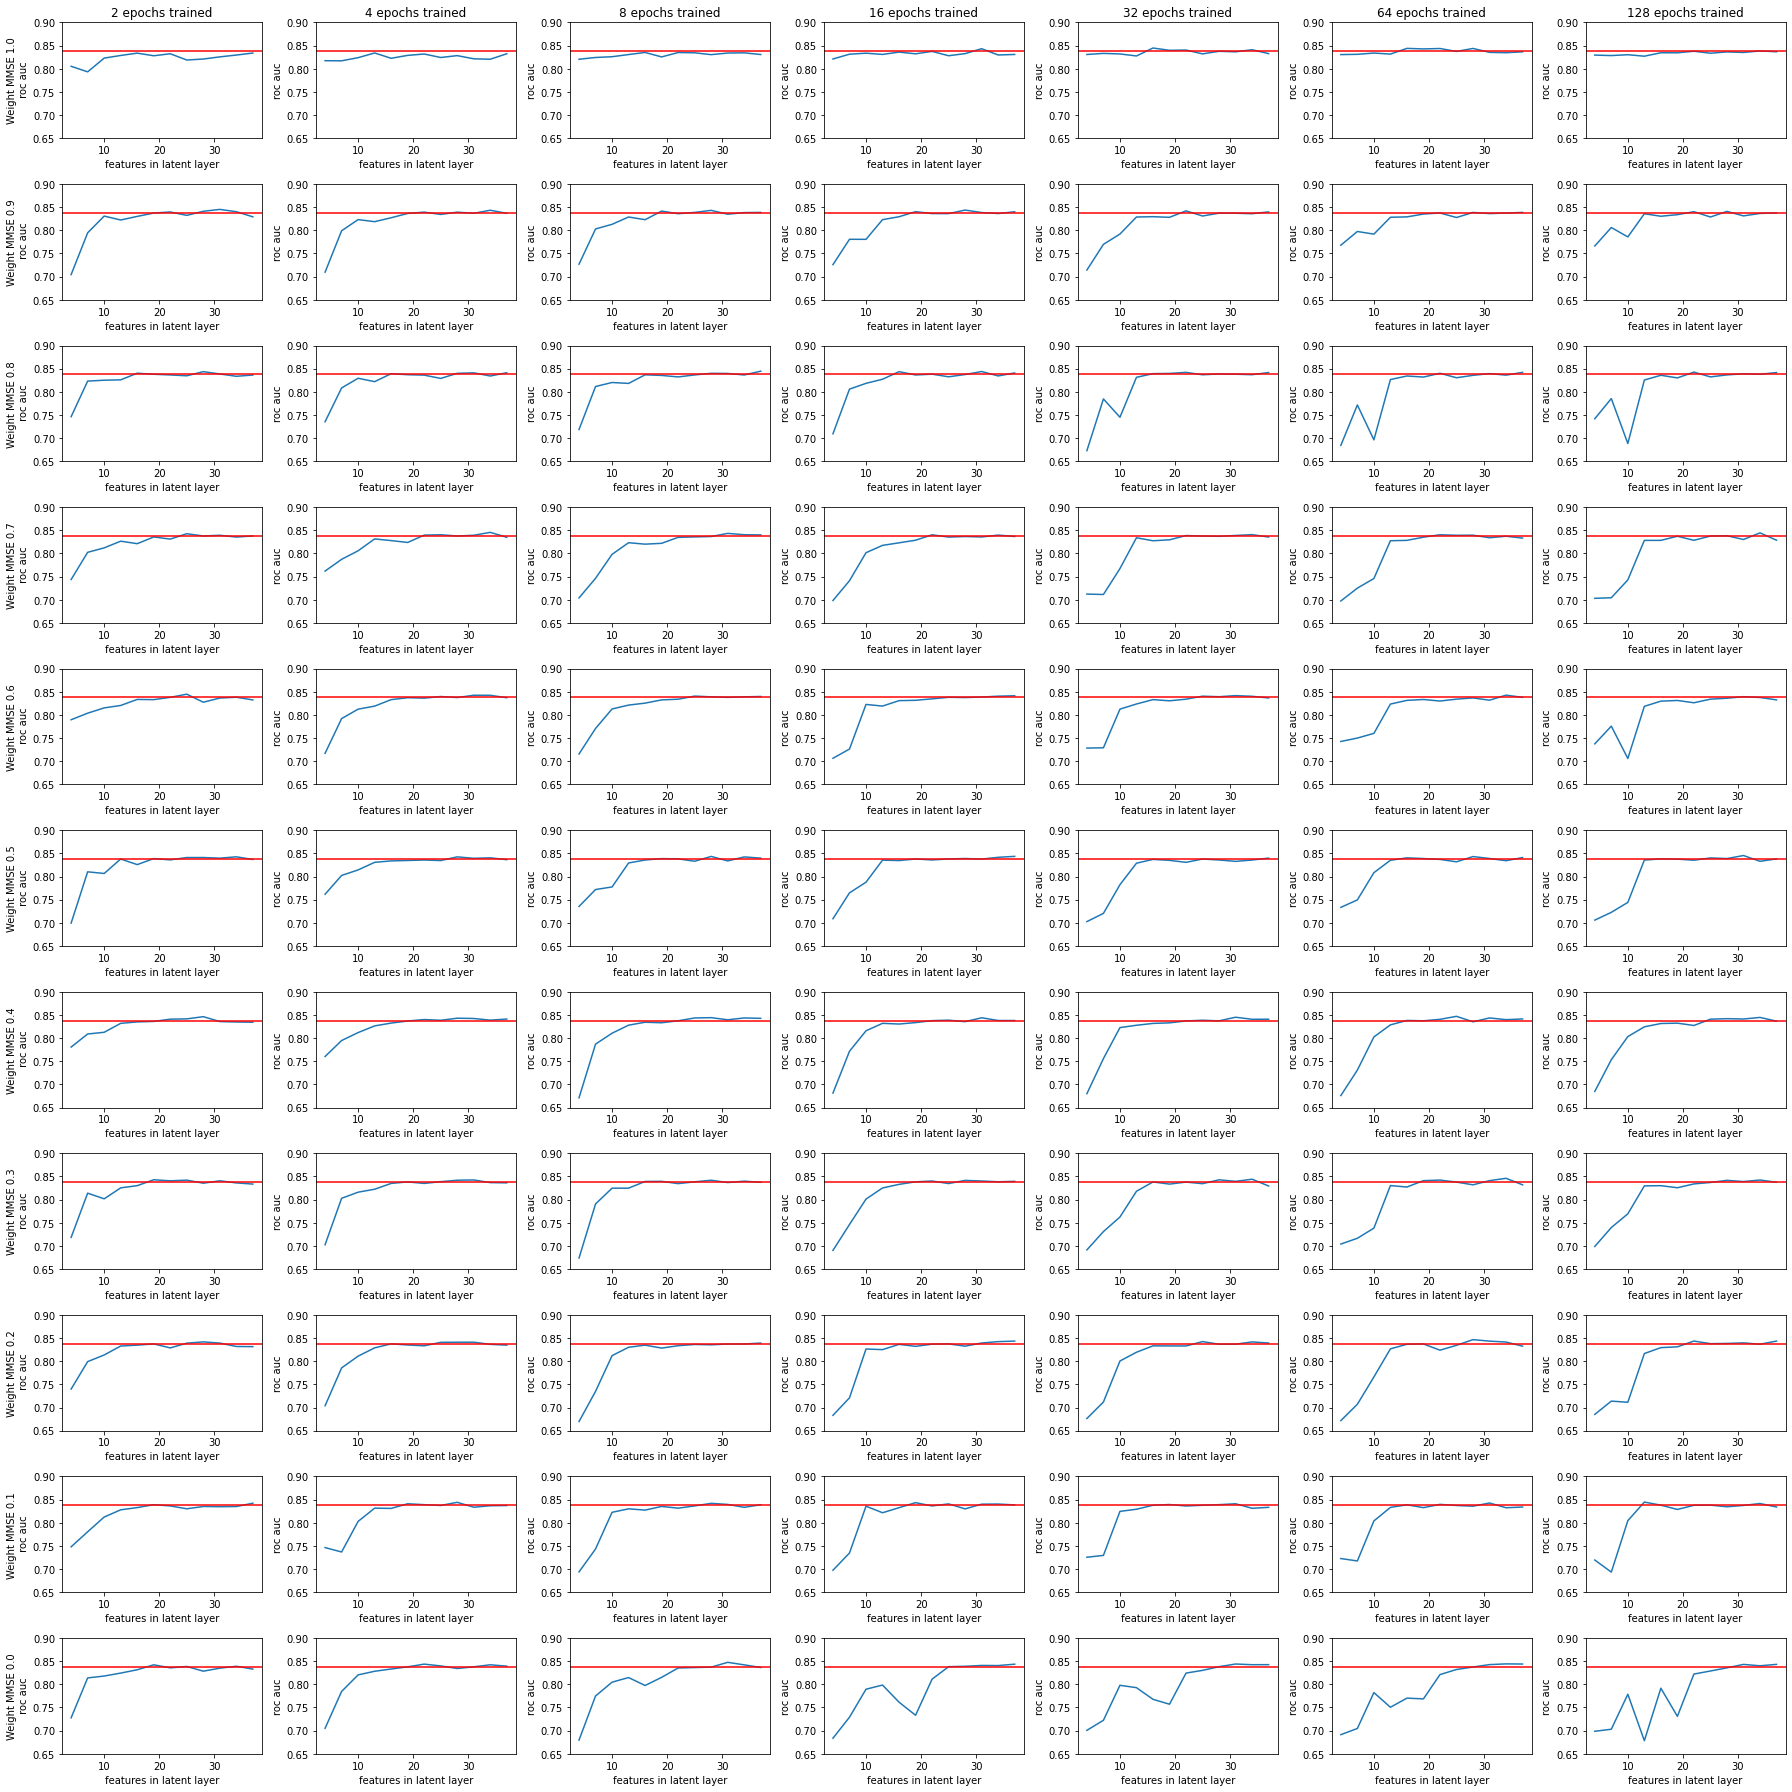

_Figure 14_: Small mulitple graph of ROC-AUC by number of features, weights and number of epochs trained compared to baseline

In [36]:
# Plot Grid
import numpy as np
import torch
import time

weight_test = np.array(range(0, 11, 1)) / 10 
epochs_test = [1] + list(range(1, 7, 1))    
shape_test = np.array(range(4, 40, 3)) 

epochs_values = np.cumsum(2**np.array(epochs_test))

t_roc_auc = torch.flip(torch.FloatTensor(roc_auc_grid).reshape(len(weight_test), len(shape_test), len(epochs_values)), [0])
weight_test = np.flip(weight_test)

# Set or get baseline!
baseline_roc_auc = 0.83779

fig, axes = plt.subplots(nrows=weight_test.shape[0], ncols=epochs_values.shape[0], figsize=(25, 25))
for w in range(weight_test.shape[0]):
    for e in range(epochs_values.shape[0]):
        axes[w][e].plot(shape_test, t_roc_auc[w][:,e], label = 'roc_auc')
        axes[w][e].axhline(y = baseline_roc_auc, color = 'r', label = 'baseline roc-auc')
        axes[w][e].set_ylabel(f'Weight MMSE {weight_test[w]}\n roc auc') if e == 0 else axes[w][e].set_ylabel('roc auc')
        if w == 0: axes[w][e].set_title(f'{epochs_values[e]} epochs trained') 
        axes[w][e].set_xlabel("features in latent layer")
        axes[w][e].set_ylim([0.65, 0.9])
fig.tight_layout()
plt.show()
h.printmd(f'_Figure 14_: Small mulitple graph of ROC-AUC by number of features, weights and number of epochs trained compared to baseline')

In this small multiple chart for each column the number of epochs trained is the same. Note that it increases exponentially. Similarly, for each row the weight of the MMSE loss is kept the same with 1 at the top row and 0 at the bottom row. In each subplot the ROC-AUC with regards to the number of latent features, given the respective parameters, is shown. The ROC-AUC is calculated based on the last five iterations of the credit scoring model in the acceptance loop like in all the other examples.

All subplots show the same general direction. With a low number of latent features the credit scoring model performs poorly on the encoded data. As the number of latent features increases the model performance increases until it reaches about the same or slightly better performance as the model on the unencoded data. This we have seen already in section 5.3 above. This seems to be the most important parameter.

Comparing the rows, it stands out that in the first and the last row, the number of features needed until the baseline performance is reached, is much higher than in all the other rows. For the 0.0 MMSE loss weight this seems plausible since the reconstruction in this case is not directly controlled. Only the MMSE loss is not expected to improve the performance due to improving only the reconstruction of the existing data. This at least shows that our idea to combine these targets has a positive influence while the exact configuration doesn’t seem to make a big difference. We assume this is because the subpopulations are already very similarly distributed and the KLDiv loss reaches its optimum very fast and subsequent training only improves the reconstruction loss which seems to be unnecessary. 

Comparing the columns, we see that, at least for lower numbers of features, the performance decreases with the number of epochs trained. In tendence it takes a higher number of latent features until we reach the baseline performance. This hints that for low number of features the neural network loses the information relevant for the distinction between good and bad applicants. This might be in part due to our implementation which tries to make the distribution of good and bad subsamples as similar as possible. It would be interesting to see if this would change if we would train our Autoencoder on rejected vs accepted instead. It also might be mitigated with the Variational Fair Autoencoder described by Louizos et al. (2017), which adds an additional part to keep as much variance between the subsamples. We were not able to test these two ideas in the given time. But with more latent features this effect already is not visible anymore. 

Overall, the most influential parameter seems to be the number of latent features. With the inclusion of a distribution mismatch around 15 latent features seem to be enough to not hamper the performance. Then already very few epochs with our current configuration are enough to train the net sufficiently further training is doesn’t improve the performance of the credit scoring model significantly better.

## 6. Conclusion

Overall, the approach does work. It is not much, but we were consistently able to improve the performance of a model that was trained on the original data set by using a model that was trained on encoded data. Results never really improve by more than one percentage point of ROC-AUC which equals an improvement of somewhere between one and two percent, though. However, depending on the amounts and volumes of applications the credit scoring models operate on in the real world this could still result in a significant monetary improvement for loan givers. As we showed, with minor simplifications, the method is not too complicated to implement and certainly feasible for large scale loaning companies dealing with strong sampling bias in their models.

An interesting result is also that most of the data sets are very compressible by simple Autoencoder setups. We noticed this especially for the GMSC data set, with which we evaluated our approaches extensively. In its original form it consisted of 68 features, but we were able to maintain the full predictive performance on not more than sixc latent features. This is an important finding, since it is basically a prerequisite to the idea of using an encoded, compressed version of the data to fight sampling bias in models for that data.

Certainly, the most astonishing finding regards the influence different hyper parameters have on the approach, or rather _do not_ have. As considerably discussed in the previous part, the configuration of the three parameters we chose to investigate in the end could never really influence the final performance, as long as the number of latent features was big enough. Neither the number of epochs we decided to train our Autoencoder, nor the weighting of the different loss function terms could significantly increase or decrease the final ROC-AUC. They all converged on a plateau slightly above the unencoded baseline ROC-AUC and were then unaffected by the configuration of these parameters. As mentioned a few times now, the only parameter that had a clear trend associated to it was the number of latent features that were present in the Autoencoder. There always seemed to be a threshold of latent features that needed to be surpassed before the encoded ROC-AUC settled above the baseline performance. This threshold was depended on the other two parameters and was genuinely higher with a) more epochs trained and b) a more extreme loss function configuration (meaning only MMSE or only KLDiv). However this relationship only holds up to about 20 latent features, after which no other parameter had any measurable influence. To be frank we did not come up with completely plausible explanations to why this is the case. Especially, why the weighting of our two loss function terms seems to have so little influence. We at least noticed, that a combination of both terms, gives slightly better results than each on their own. Still, it seems that they internally both nudged the Autoencoder in very similar directions during training, which luckily for us produced good results.
We cannot say the same about the MMD loss, as it drastically worsened the results every time it was present in our loss function. To be fair that may be because of a faulty implementation however, as we did not investigate it really much in the end.

We also tried the experiment with an “almost fully variational” Autoencoder, where we tried to match the encoded distribution to a standard normal distribution instead of matching the distributions of GOOD and BAD subsets, but the results were very similar and at best a little bit worse.

To give an outlook of things we would consider worthy to explore in the future, this is maybe a good first step, as we did not manage to try out a true variational Autoencoder. As mentioned, our approach was already pretty close to a variational Autoencoder, so we don’t expect the results of a true variational Autoencoder to be really much better. It is worth a try though as we cannot be sure by any means. Also, one could focus on more extensive tests with different models on different data sets, as we focused on LightGBM on GMSC. An important step before using the approach in production would also be to implement the training of a new Autoencoder every iteration of training a new model, as this is something we simplified by training an Autoencoder on the complete dataset before the simulation.

Certainly, it would be interesting to investigate further hyper parameters, like the number of hidden features, learning rates, batch sizes, etc. to see if their lies any explanation in these configurations that we missed.


## 7. References
Baldi, Pierre, ‘Autoencoders, Unsupervised Learning, and Deep Architectures’, in Proceedings of ICML Workshop on Unsupervised and Transfer Learning (presented at the Proceedings of ICML Workshop on Unsupervised and Transfer Learning, JMLR Workshop and Conference Proceedings, 2012), pp. 37–49 <https://proceedings.mlr.press/v27/baldi12a.html> [accessed 12 February 2022]

Baldi, Pierre, and Kurt Hornik, ‘Neural Networks and Principal Component Analysis: Learning from Examples without Local Minima’, Neural Networks, 2.1 (1989), 53–58 <https://doi.org/10.1016/0893-6080(89)90014-2>

Banasik, J, and J Crook, ‘Credit Scoring, Augmentation and Lean Models’, Journal of the Operational Research Society, 56.9 (2005), 1072–81 <https://doi.org/10.1057/palgrave.jors.2602017>

BANASIK, J., and J. CROOK, ‘Does Reject Inference Really Improve the Performance of Application Scoring Models?’, Journal of Banking & Finance, 28.4 (2004), 857–74 <https://doi.org/10.1016/s0378-4266(03)00203-6>

Banasik, J., J. Crook, and L. Thomas, ‘Sample Selection Bias in Credit Scoring Models’, Journal of the Operational Research Society, 54.8 (2003), 822–32 <https://doi.org/10.1057/palgrave.jors.2601578>

Banasik, John, and Jonathan Crook, ‘Reject Inference, Augmentation, and Sample Selection’, European Journal of Operational Research, 183.3 (2007), 1582–94 <https://doi.org/10.1016/j.ejor.2006.06.072>

Bank, Dor, Noam Koenigstein, and Raja Giryes, ‘Autoencoders’, ArXiv:2003.05991 [Cs, Stat], 2021 <http://arxiv.org/abs/2003.05991> [accessed 30 November 2021]

Durand, David, Risk Elements in Consumer Instalment Financing (National Bureau of Economic Research, 1 January 1941) <https://www.nber.org/books-and-chapters/risk-elements-consumer-instalment-financing> [accessed 16 January 2022]

Feelders, A., ‘An Overview of Model Based Reject Inference for Credit Scoring’, 2001 <https://www.semanticscholar.org/paper/An-Overview-of-Model-Based-Reject-Inference-for-Feelders/6b0b6cb98e69304283656460d66008a10a33331e> [accessed 25 November 2021]

Feelders, A.j., ‘Credit Scoring and Reject Inference with Mixture Models’, Intelligent Systems in Accounting, Finance and Management, 9.1 (2000), 1–8 <https://doi.org/10.1002/(SICI)1099-1174(200003)9:1<1::AID-ISAF177>3.0.CO;2-#>

Filchenkov, Andrey, Natalia Khanzhina, Arina Tsai, and Ivan Smetannikov, ‘Regularization of Autoencoders for Bank Client Profiling Based on Financial Transactions’, Risks, 9.3 (2021), 54 <https://doi.org/10.3390/risks9030054>

Joanes, Derrick N., ‘Reject Inference Applied to Logistic Regression for Credit Scoring’, IMA Journal of Management Mathematics, 5.1 (1993), 35–43 <https://doi.org/10.1093/imaman/5.1.35>

Kingma, Diederik P., and Max Welling, ‘Auto-Encoding Variational Bayes’, ArXiv:1312.6114 [Cs, Stat], 2014 <http://arxiv.org/abs/1312.6114> [accessed 12 February 2022]

Kozodoi, Nikita, Panagiotis Katsas, Stefan Lessmann, Luis Moreira-Matias, and Konstantinos Papakonstantinou, ‘Shallow Self-Learning for Reject Inference in Credit Scoring’, ECML PKDD 2019. Lecture Notes in Computer Science, Vol 11908. Springer, Cham, 2019 <https://doi.org/10.1007/978-3-030-46133-1_31>

Lessmann, Stefan, Bart Baesens, Hsin-Vonn Seow, and Lyn C. Thomas, ‘Benchmarking State-of-the-Art Classification Algorithms for Credit Scoring: An Update of Research’, European Journal of Operational Research, 247.1 (2015), 124–36 <https://doi.org/10.1016/j.ejor.2015.05.030>

Little, Roderick J. A., and Donald B. Rubin, Statistical Analysis with Missing Data (Hoboken, NJ, USA: John Wiley & Sons, Inc., 2002) <https://doi.org/10.1002/9781119013563>

Louizos, Christos, Kevin Swersky, Yujia Li, Max Welling, and Richard Zemel, ‘The Variational Fair Autoencoder’, ArXiv:1511.00830 [Cs, Stat], 2017 <http://arxiv.org/abs/1511.00830> [accessed 25 November 2021]

Plaut, Elad, ‘From Principal Subspaces to Principal Components with Linear Autoencoders’, ArXiv:1804.10253 [Cs, Stat], 2018 <http://arxiv.org/abs/1804.10253> [accessed 12 February 2022]

Roderick J A Little, author, Statistical Analysis with Missing Data, Wiley Series in Probability and Statistics, Third edition. (Hoboken, NJ: Wiley, 2020)

Rumelhart, David E., James L. McClelland, and AU, Parallel Distributed Processing: Explorations in the Microstructure of Cognition: Foundations (The MIT Press, 1986) <https://doi.org/10.7551/mitpress/5236.001.0001>

